# 1. Analysis of the personalities of the Big Five (IPIP-FFM)

The Big Five personality test is used to see how an individual reacts to certain situations. The method is used by psychologists all over the world to define, for example, an individual's professional career. This analysis uses the Big-Five Factor Markers from the **International Personality Item Pool**, developed by **Goldberg** (1992).

The test consists of fifty items that you must rate on how true they are about you on a five point scale where 1=Disagree, 3=Neutral and 5=Agree. It takes most people 3-8 minutes to complete. Example:

| Big Five        | Label | Phrased | Prompt                                                   |
|-----------------|-------|---------|----------------------------------------------------------|
| Extraversion    | EXT1  | P       | I am the life of the party.                              |
| Neuroticism     | EST2  | N       | I am relaxed most of the time.                           |
| Agreeableness   | AGR1  | N       | I feel little concern for others.                        |
| Contentiousness | CSN5  | P       | I get chores done right away.                            |
| Openness        | OPN1  | P       | I have a rich vocabulary.                                |

There are questions with negative weight (N) and positive weight (P). The dataset to be explored is the *IPIP-FFM-data-8Nov2018* latest version available.

In [1]:
import warnings

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

warnings.filterwarnings("ignore")
pd.options.display.max_columns = 10

%matplotlib inline

### 1.1 Read the dataset

In [2]:
data = pd.read_csv("datasets/IPIP-FFM-data-8Nov2018/data-final.csv", delimiter="\t")

datalen = len(data)
assert datalen > 100000

data.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,...,endelapse,IPC,country,lat_appx_lots_of_err,long_appx_lots_of_err
0,4.0,1.0,5.0,2.0,5.0,...,6,1,GB,51.5448,0.1991
1,3.0,5.0,3.0,4.0,3.0,...,11,1,MY,3.1698,101.706
2,2.0,3.0,4.0,4.0,3.0,...,7,1,GB,54.9119,-1.3833
3,2.0,2.0,2.0,3.0,4.0,...,7,1,GB,51.75,-1.25
4,3.0,3.0,3.0,3.0,5.0,...,17,2,KE,1.0,38.0


### 1.2 Inspecting the dataframe

In [3]:
print(f"Dataset shape: {data.shape}")
data.describe()

Dataset shape: (1015341, 110)


,EXT1,EXT2,EXT3,EXT4,EXT5,...,screenh,introelapse,testelapse,endelapse,IPC
count,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,1.013558e+06,...,1.013275e+06,1.013275e+06,1.013558e+06,1.015341e+06,1.015341e+06
mean,2.648067e+00,2.773115e+00,3.288349e+00,3.140595e+00,3.276960e+00,...,8.262611e+02,9.590748e+02,6.754233e+02,2.701410e+03,1.045211e+01
std,1.264407e+00,1.323943e+00,1.215006e+00,1.237442e+00,1.277593e+00,...,1.802490e+02,5.104005e+04,2.017864e+04,1.483898e+06,3.982879e+01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,2.000000e+00,...,7.200000e+02,5.000000e+00,1.710000e+02,9.000000e+00,1.000000e+00
50%,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,3.000000e+00,...,7.680000e+02,1.000000e+01,2.240000e+02,1.300000e+01,1.000000e+00
75%,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,4.000000e+00,...,9.000000e+02,3.000000e+01,3.130000e+02,1.800000e+01,2.000000e+00
max,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00,...,8.802000e+03,2.944307e+07,1.189272e+07,1.493327e+09,7.250000e+02


### 1.3 Check and remove missing value

In [4]:
print(f"Dataset total: {datalen}")
print(f"Is there any missing value? {data.isnull().values.any()}")
print(f"How many missing values: {data.isnull().values.sum()}")

data = data.dropna(inplace=False)

print(f"Number of participants after eliminating missing values: {len(data)}")
print(f"Number of countries: {len(data.country.unique())}")

Dataset total: 1015341
Is there any missing value? True
How many missing values: 186358
Number of participants after eliminating missing values: 1012050
Number of countries: 223


## 2. Countries

The tests were carried out by participants from several countries. People of different culture, age and education.

### 2.1 Counting the answers from each country

In [5]:
countries = (
    pd.DataFrame(data.country.value_counts())
    .T.drop("NONE", axis=1)
    .rename(
        columns={x.alpha_2: x.alpha_3 for x in pycountry.countries},
        index={"country": "count"},
    )
)

countries.head()

,USA,GBR,CAN,AUS,PHL,...,MAF,GNQ,FLK,MHL,SHN
count,545414,66373,61751,49595,19839,...,1,1,1,1,1


### 2.2 Creating ranking by countries

In [6]:
countries_rank = countries.T.rename_axis("iso_a3").reset_index()
countries_rank["log"] = np.log(countries_rank["count"])
countries_rank["rank"] = countries_rank["count"].rank()
countries_rank.T.head()

,0,1,2,3,4,...,217,218,219,220,221
iso_a3,USA,GBR,CAN,AUS,PHL,...,MAF,GNQ,FLK,MHL,SHN
count,545414,66373,61751,49595,19839,...,1,1,1,1,1
log,13.2093,11.103046,11.030865,10.811645,9.895405,...,0.0,0.0,0.0,0.0,0.0
rank,222.0,221.0,220.0,219.0,218.0,...,5.5,5.5,5.5,5.5,5.5


### 2.3 Visualize assessment by country

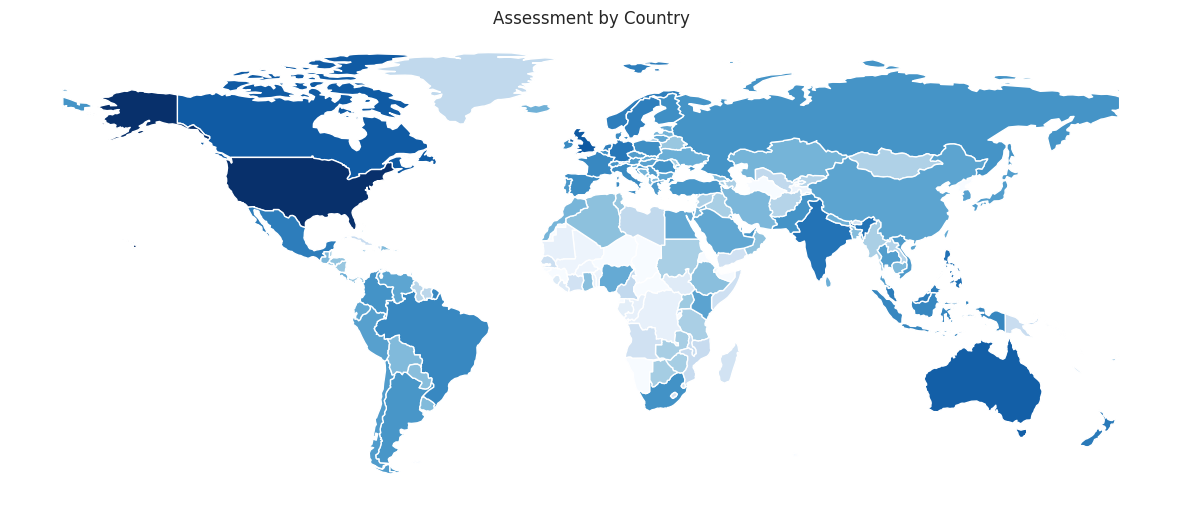

In [7]:
sns.set_style("white")

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world[world.continent != "Antarctica"]
wmap = pd.merge(world, right=countries_rank, how="left", on="iso_a3").fillna(0)

fig, ax = plt.subplots(figsize=(15, 15))
ax.set_xticks([])
ax.set_yticks([])
ax.set_title("Assessment by Country")
wmap.drop(159).plot(column="log", cmap="Blues", ax=ax)
plt.box()

## 3. Big Five personality traits

  * Openness
  * Conscientiousness
  * Extraversion
  * Agreeableness
  * Neuroticism
  
The traits are also known as **O.C.E.A.N**.

### 3.1. Questions and answers related to Extroversion Personality

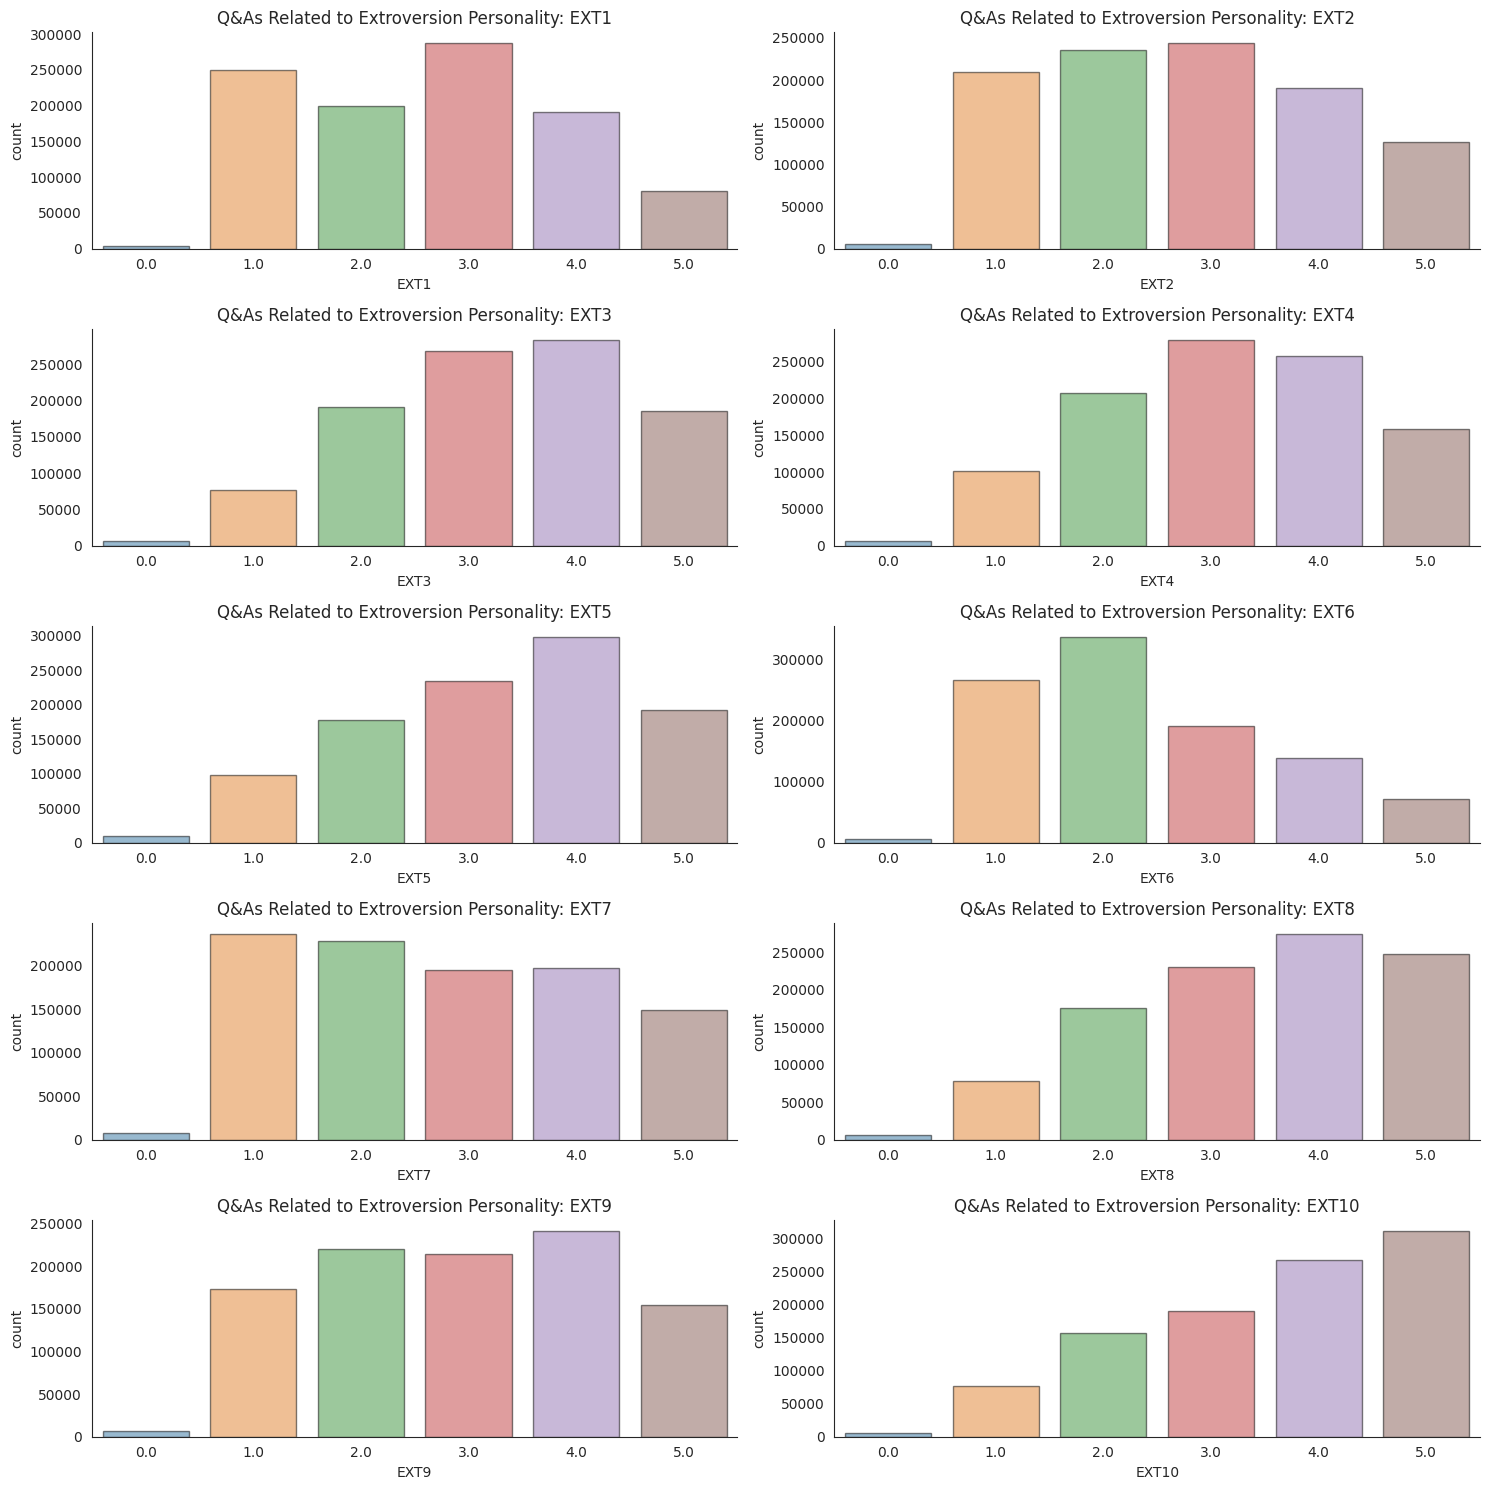

In [8]:
plt.figure(figsize=[15, 15])

target = [
    "EXT1",
    "EXT2",
    "EXT3",
    "EXT4",
    "EXT5",
    "EXT6",
    "EXT7",
    "EXT8",
    "EXT9",
    "EXT10",
]
n = 1

for x in target:
    plt.subplot(5, 2, n)
    sns.countplot(x=x, edgecolor="black", alpha=0.5, data=data)
    sns.despine()
    plt.title(f"Q&As Related to Extroversion Personality: {x}")
    n = n + 1

plt.tight_layout()
plt.show()

### 3.2. Questions and answers related to Neuroticism Personality

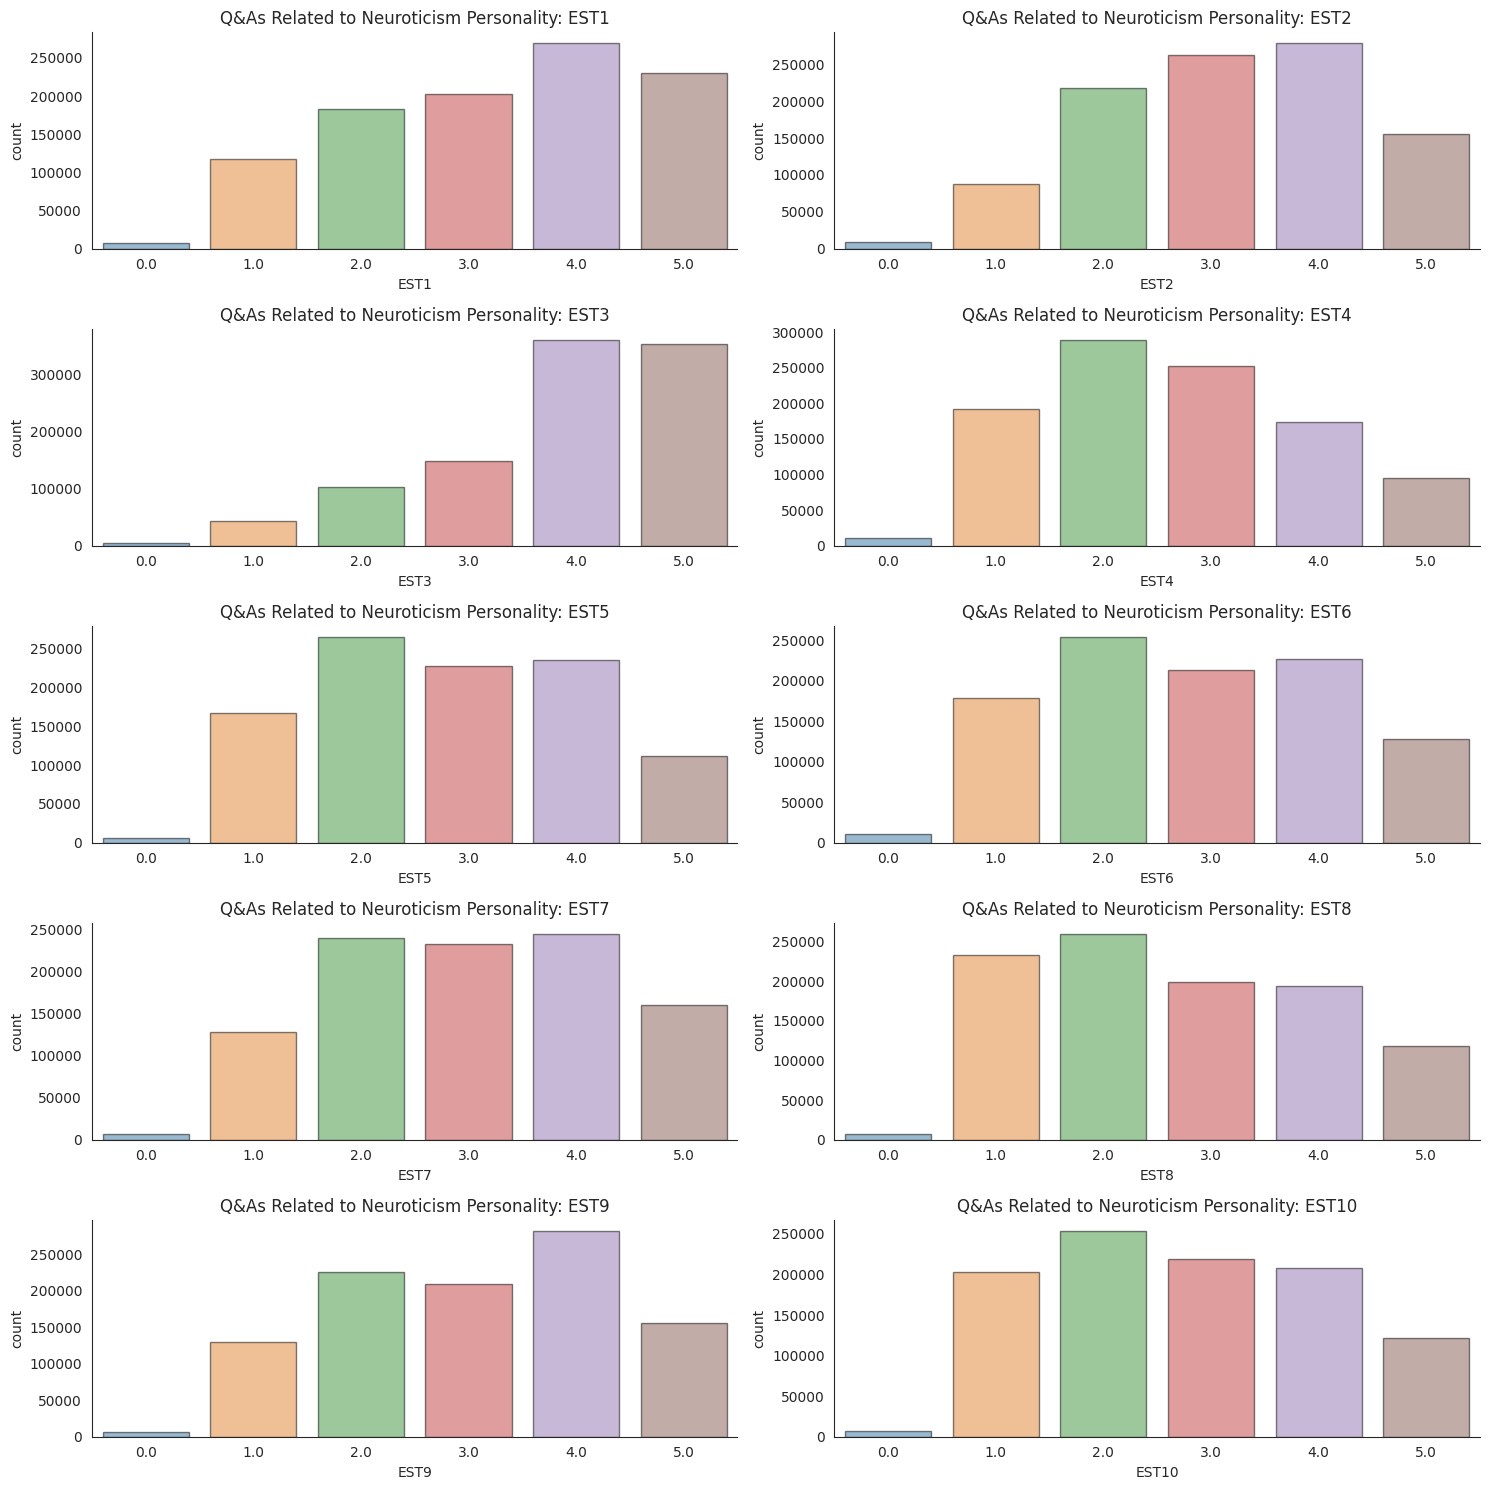

In [9]:
plt.figure(figsize=[15, 15])

target = [
    "EST1",
    "EST2",
    "EST3",
    "EST4",
    "EST5",
    "EST6",
    "EST7",
    "EST8",
    "EST9",
    "EST10",
]
n = 1

for x in target:
    plt.subplot(5, 2, n)
    sns.countplot(x=x, edgecolor="black", alpha=0.5, data=data)
    sns.despine()
    plt.title(f"Q&As Related to Neuroticism Personality: {x}")
    n = n + 1

plt.tight_layout()
plt.show()

### 3.3. Questions and answers related to Agreeable Personality

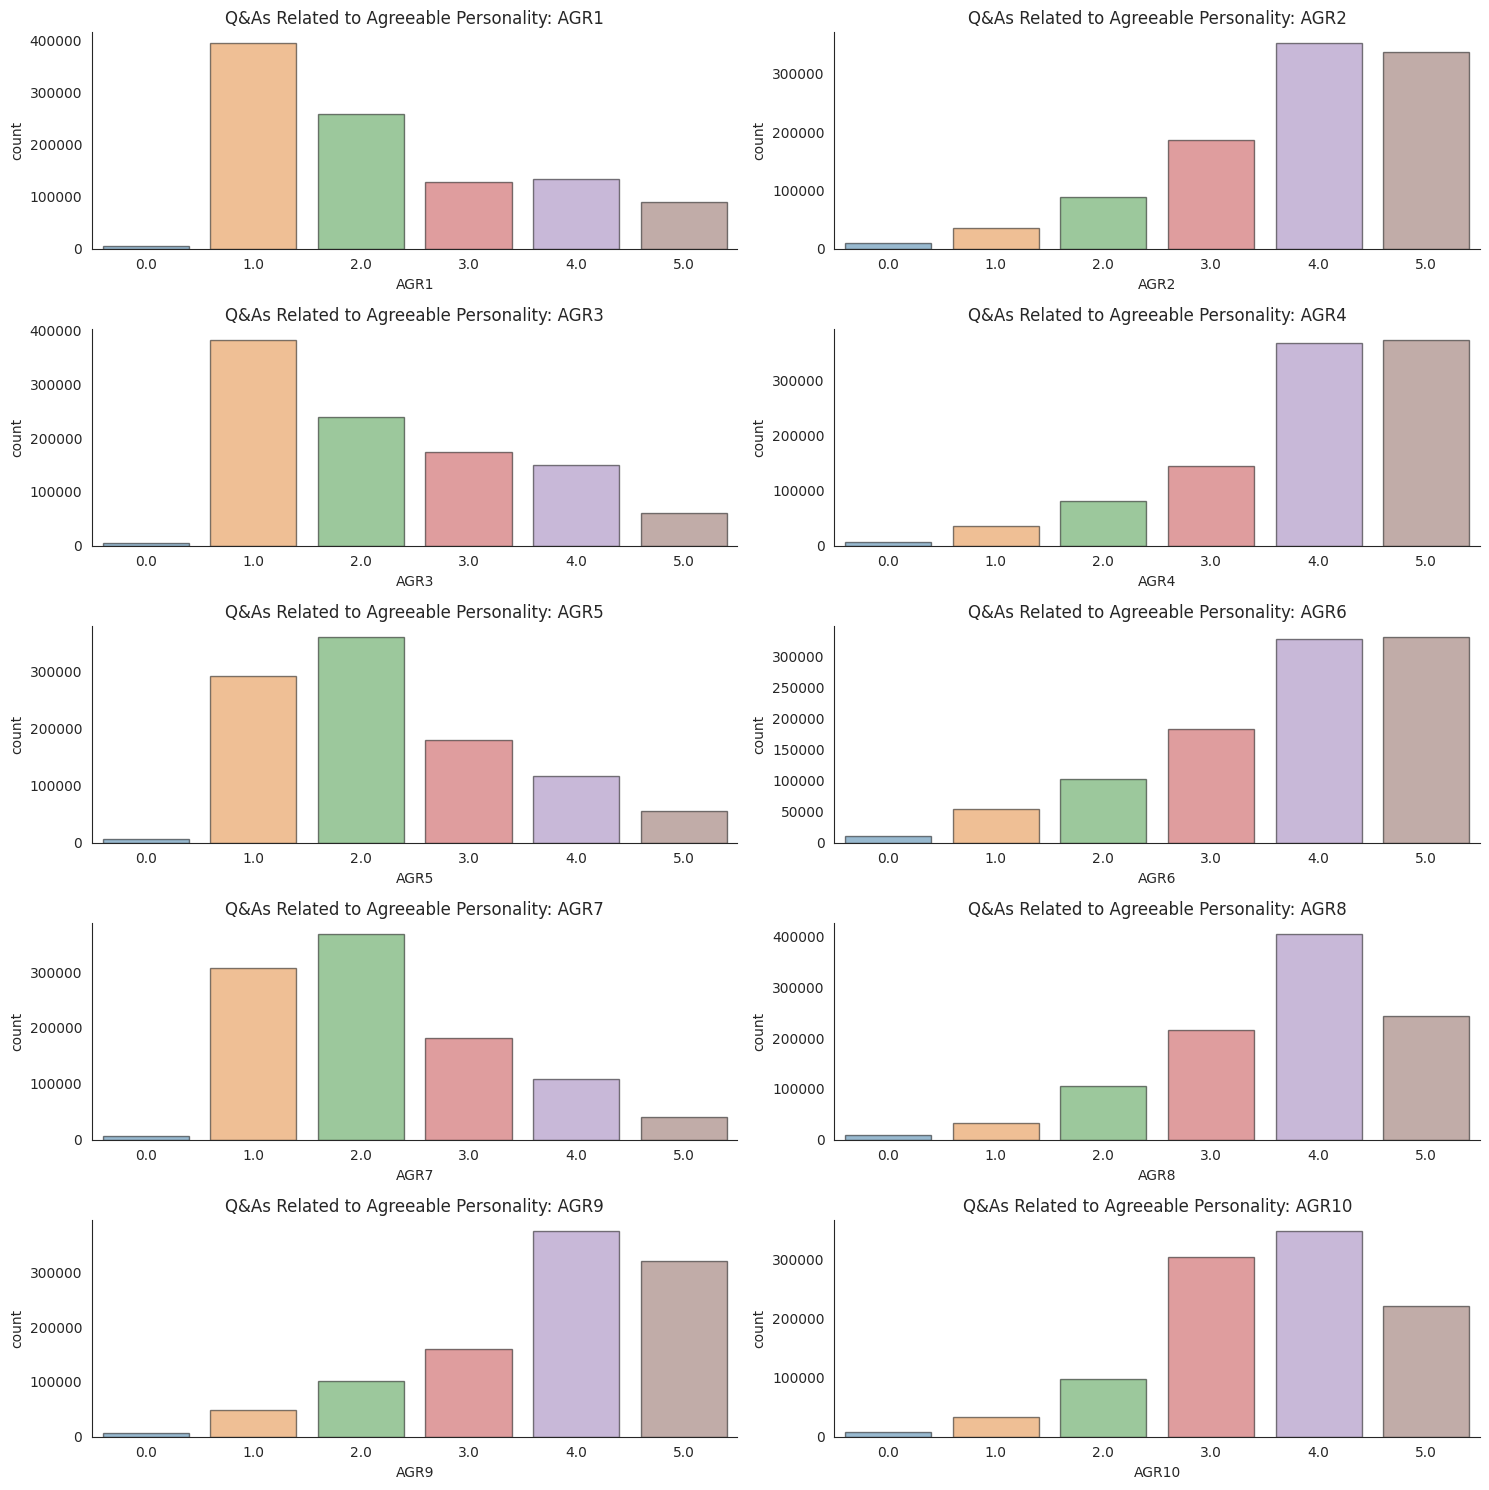

In [10]:
plt.figure(figsize=[15, 15])

target = [
    "AGR1",
    "AGR2",
    "AGR3",
    "AGR4",
    "AGR5",
    "AGR6",
    "AGR7",
    "AGR8",
    "AGR9",
    "AGR10",
]
n = 1

for x in target:
    plt.subplot(5, 2, n)
    sns.countplot(x=x, edgecolor="black", alpha=0.5, data=data)
    sns.despine()
    plt.title(f"Q&As Related to Agreeable Personality: {x}")
    n = n + 1

plt.tight_layout()
plt.show()

### 3.4. Questions and answers related to Conscientious Personality

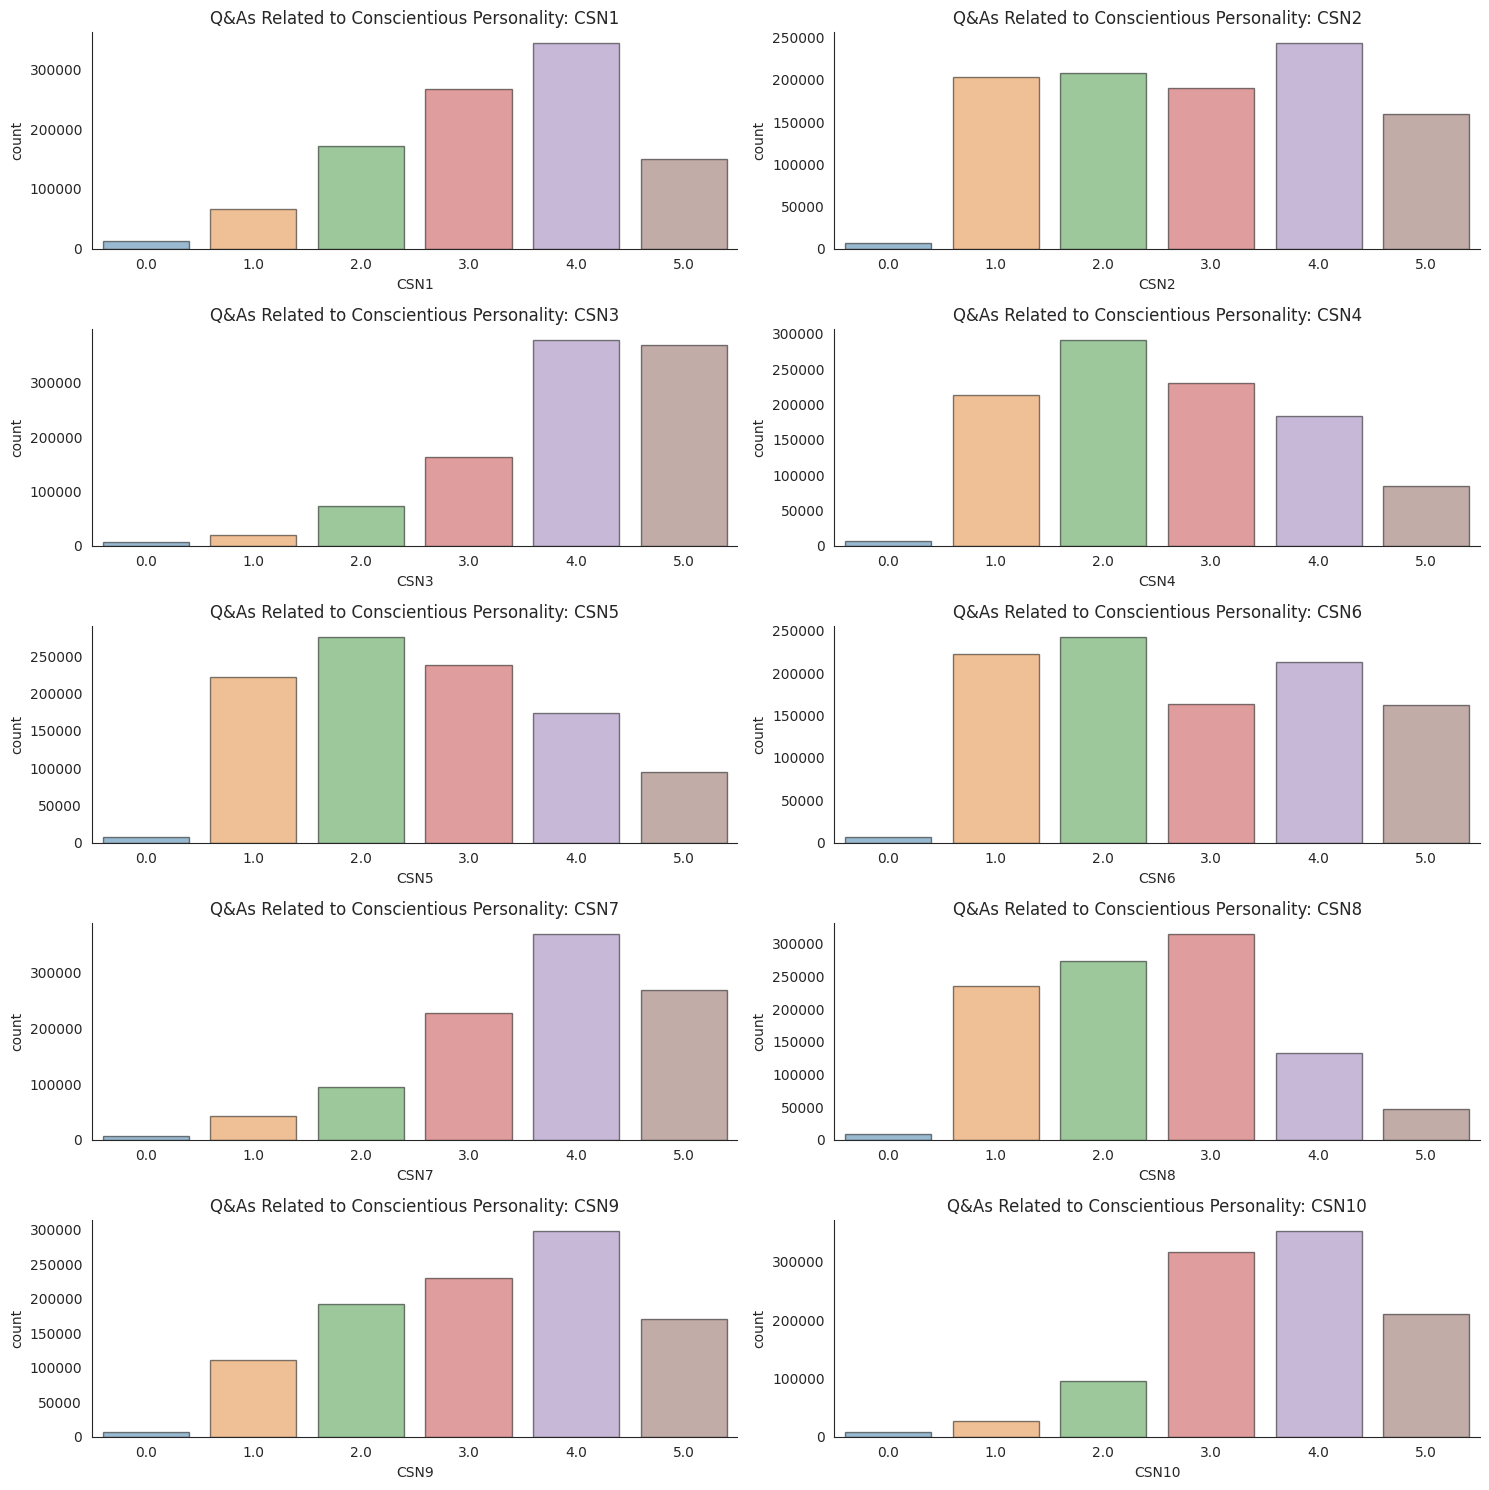

In [11]:
plt.figure(figsize=[15, 15])

target = [
    "CSN1",
    "CSN2",
    "CSN3",
    "CSN4",
    "CSN5",
    "CSN6",
    "CSN7",
    "CSN8",
    "CSN9",
    "CSN10",
]
n = 1

for x in target:
    plt.subplot(5, 2, n)
    sns.countplot(x=x, edgecolor="black", alpha=0.5, data=data)
    sns.despine()
    plt.title(f"Q&As Related to Conscientious Personality: {x}")
    n = n + 1

plt.tight_layout()
plt.show()

### 3.5. Questions and answers related to Open Personality

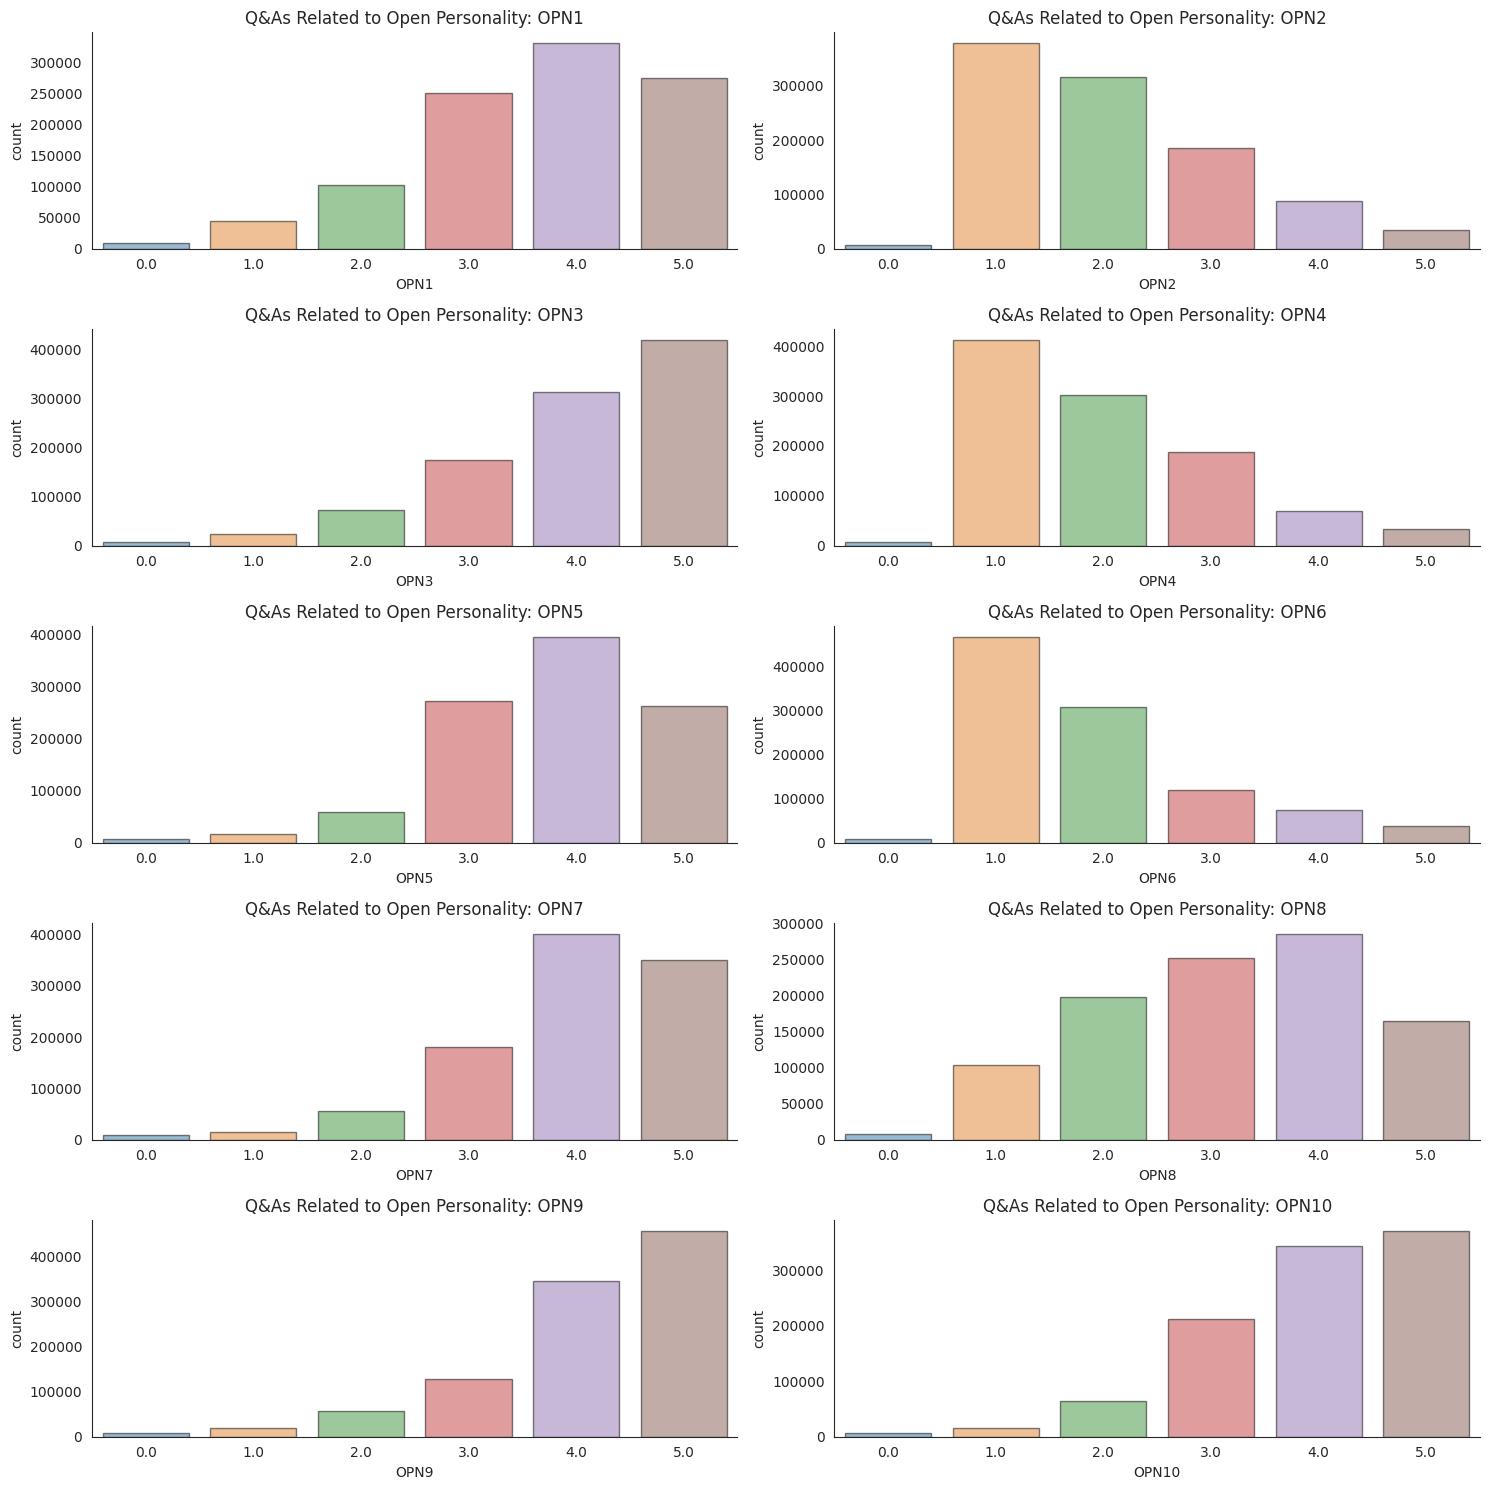

In [12]:
plt.figure(figsize=[15, 15])

target = [
    "OPN1",
    "OPN2",
    "OPN3",
    "OPN4",
    "OPN5",
    "OPN6",
    "OPN7",
    "OPN8",
    "OPN9",
    "OPN10",
]
n = 1

for x in target:
    plt.subplot(5, 2, n)
    sns.countplot(x=x, edgecolor="black", alpha=0.5, data=data)
    sns.despine()
    plt.title(f"Q&As Related to Open Personality: {x}")
    n = n + 1

plt.tight_layout()
plt.show()

## 4. Clustering

In [13]:
X = data.copy()

X.drop(X.columns[50:107], axis=1, inplace=True)
X.drop(X.columns[51:], axis=1, inplace=True)

X.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,...,OPN7,OPN8,OPN9,OPN10,country
0,4.0,1.0,5.0,2.0,5.0,...,5.0,3.0,4.0,5.0,GB
1,3.0,5.0,3.0,4.0,3.0,...,4.0,2.0,5.0,3.0,MY
2,2.0,3.0,4.0,4.0,3.0,...,5.0,3.0,4.0,4.0,GB
3,2.0,2.0,2.0,3.0,4.0,...,4.0,4.0,3.0,3.0,GB
4,3.0,3.0,3.0,3.0,5.0,...,5.0,3.0,5.0,5.0,KE


### 4.1 Clustering participants into 5 groups

K-means is a centroid-based algorithm, or a distance-based algorithm, where we calculate the distances to assign a point to a cluster. In K-Means, each cluster is associated with a centroid.

In [14]:
model1 = X.drop("country", axis=1)
kmeans = KMeans(n_clusters=5)
kfit = kmeans.fit(model1)

### 4.2 Predicting the Clusters

In [15]:
predictions = kfit.labels_
model1["Clusters"] = predictions
model1.head()

,EXT1,EXT2,EXT3,EXT4,EXT5,...,OPN7,OPN8,OPN9,OPN10,Clusters
0,4.0,1.0,5.0,2.0,5.0,...,5.0,3.0,4.0,5.0,0
1,3.0,5.0,3.0,4.0,3.0,...,4.0,2.0,5.0,3.0,3
2,2.0,3.0,4.0,4.0,3.0,...,5.0,3.0,4.0,4.0,3
3,2.0,2.0,2.0,3.0,4.0,...,4.0,4.0,3.0,3.0,4
4,3.0,3.0,3.0,3.0,5.0,...,5.0,3.0,5.0,5.0,0


### 4.3 Summing up the different questions groups

In [16]:
cols = list(model1)
ext = cols[0:10]
est = cols[10:20]
agr = cols[20:30]
csn = cols[30:40]
opn = cols[40:50]

sigma = pd.DataFrame()
sigma["extraversion"] = model1[ext].sum(axis=1) / 10
sigma["neuroticism"] = model1[est].sum(axis=1) / 10
sigma["agreeableness"] = model1[agr].sum(axis=1) / 10
sigma["contentiousness"] = model1[csn].sum(axis=1) / 10
sigma["openness"] = model1[opn].sum(axis=1) / 10

sigma["clusters"] = predictions
sigma.groupby("clusters").mean()

,extraversion,neuroticism,agreeableness,contentiousness,openness
clusters,,,,,
0,3.085848,2.420629,3.208420,3.106554,3.326331
1,2.966399,3.647522,3.149453,3.173350,3.245793
2,3.072272,3.420780,3.299547,3.210410,3.352302
3,3.050995,2.995313,3.188771,3.160853,3.245325
4,2.910051,2.526021,2.852548,2.915460,3.120256


### 4.4 Apply PCA

PCA is an unsupervised machine learning technique that attempts to derive a set of low-dimensional set of features from a much larger set while still preserving as much variance as possible.

In [17]:
pca = PCA(n_components=2)

df_pca = pd.DataFrame(data=pca.fit_transform(model1), columns=["PCA1", "PCA2"])
df_pca["clusters"] = predictions

df_pca.head()

,PCA1,PCA2,clusters
0,-5.710309,-1.365965,0
1,0.528954,3.094458,3
2,-0.369433,2.322433,3
3,1.420013,0.569930,4
4,-4.810740,2.336039,0


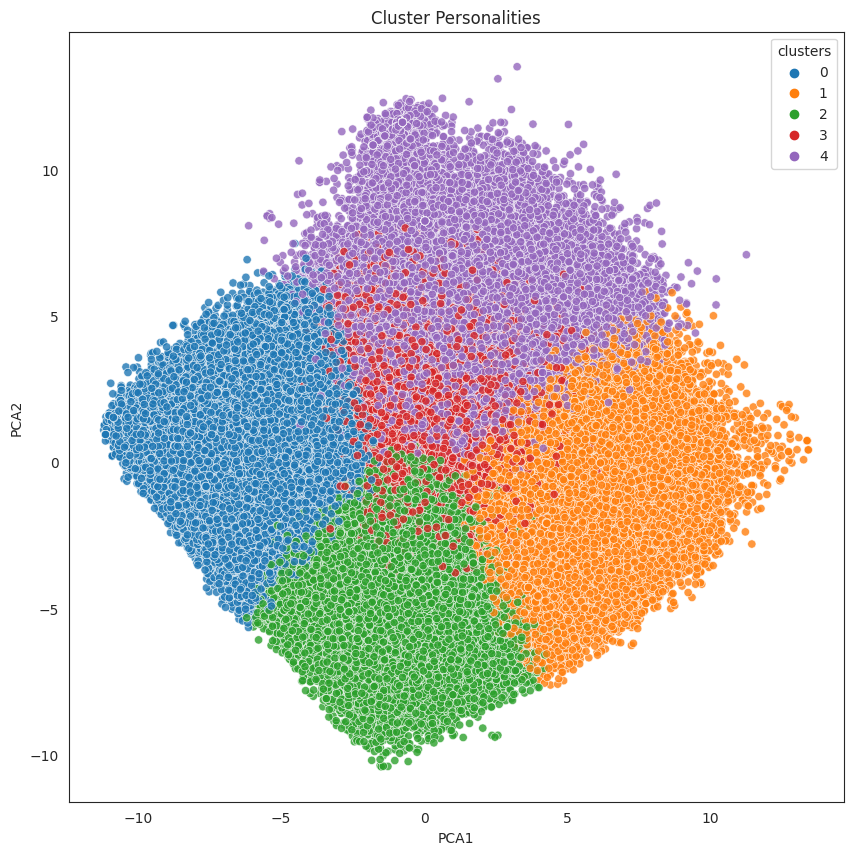

In [18]:
plt.figure(figsize=(10, 10))
sns.scatterplot(
    data=df_pca, x="PCA1", y="PCA2", hue="clusters", palette="tab10", alpha=0.8
)
plt.title("Cluster Personalities");